In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow_addons

import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import math, gc, warnings, scipy, random, os, cv2
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore')

EPOCHS = 200
BATCH_SIZE = 32
IMG_SIZE = (208, 176)
SEED = 100
CLASSES = 4
LEARNING_RATE = 0.001
ACCURACY_THRESHOLD = 0.98

     |████████████████████████████████| 1.1 MB 4.0 MB/s 


tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=4),
    }),
    total_num_examples=6608,
    splits={
        'test': 1279,
        'train': 5329,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



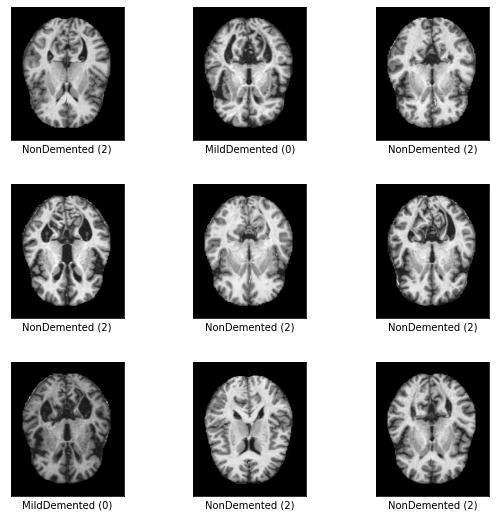

In [ ]:
builder = tfds.folder_dataset.ImageFolder("drive/MyDrive/CV/Alzheimer_Dataset/")
print(builder.info)  
ds_info = builder.info
ds_train = builder.as_dataset(split='train2', shuffle_files=True, as_supervised=True)
ds_test = builder.as_dataset(split='test', shuffle_files=True, as_supervised=True)
fig = tfds.show_examples(ds_train, builder.info)

In [ ]:
{ds_info.features['label'].str2int(x):x for x in ds_info.features['label'].names}

{0: 'MildDemented',
 1: 'ModerateDemented',
 2: 'NonDemented',
 3: 'VeryMildDemented'}

In [ ]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    print(image)
    image = tf.cast(image, tf.float32) / 255.
    
    return 2*(image - 0.5), tf.one_hot(label, depth = 4)
    
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
# ds_train = ds_train.shuffle(ds_info.splits['train[:5126]'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)
# ds_train = ds_train.shuffle(ds_info.splits['train[:5126]'].num_examples)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

Tensor("args_0:0", shape=(None, None, 3), dtype=uint8)
Tensor("args_0:0", shape=(None, None, 3), dtype=uint8)


In [ ]:
def focal_loss_custom(alpha, gamma):
    def binary_focal_loss(y_true, y_pred):
        fl = tfa.losses.SigmoidFocalCrossEntropy(alpha=alpha, gamma=gamma)
        y_true_K = tf.ones_like(y_true)
        focal_loss = fl(y_true, y_pred)
        return focal_loss
    return binary_focal_loss

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Input(shape=(208, 176, 3)),
                             tf.keras.layers.Conv2D(4, 2, activation=tf.keras.layers.LeakyReLU()),
                             tf.keras.layers.Conv2D(16, 2, activation=tf.keras.layers.LeakyReLU()),
                             tf.keras.layers.Conv2D(32, 2, activation=tf.keras.layers.LeakyReLU()),
                             tf.keras.layers.Conv2D(16, 2, activation=tf.keras.layers.LeakyReLU()),
                             tf.keras.layers.Conv2D(4, 2, activation=tf.keras.layers.LeakyReLU()),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(4, activation='softmax'),
])
# focal_loss_custom(0.2, 0.5)'sparse_categorical_crossentropy'
model.compile(metrics = ['accuracy'], 
              loss = focal_loss_custom(0.25, 4), 
              optimizer = tf.keras.optimizers.Adam(learning_rate=1e-7))
model.fit(ds_train, validation_data=ds_test, epochs = 200)

Epoch 1/200
167/167 [==============================] - 13s 68ms/step - loss: 0.0964 - accuracy: 0.4136 - val_loss: 0.0910 - val_accuracy: 0.3925
Epoch 2/200
167/167 [==============================] - 11s 66ms/step - loss: 0.0897 - accuracy: 0.4783 - val_loss: 0.0844 - val_accuracy: 0.4488
Epoch 3/200
167/167 [==============================] - 11s 67ms/step - loss: 0.0867 - accuracy: 0.4823 - val_loss: 0.0807 - val_accuracy: 0.4574
Epoch 4/200
167/167 [==============================] - 11s 68ms/step - loss: 0.0851 - accuracy: 0.4815 - val_loss: 0.0782 - val_accuracy: 0.4691
Epoch 5/200
167/167 [==============================] - 11s 68ms/step - loss: 0.0841 - accuracy: 0.4826 - val_loss: 0.0766 - val_accuracy: 0.4785
Epoch 6/200
167/167 [==============================] - 11s 68ms/step - loss: 0.0833 - accuracy: 0.4838 - val_loss: 0.0754 - val_accuracy: 0.4832
Epoch 7/200
167/167 [==============================] - 11s 69ms/step - loss: 0.0828 - accuracy: 0.4862 - val_loss: 0.0745 - val_ac

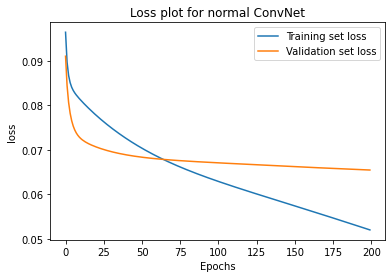

In [ ]:
plt.plot(model.history.history['loss'], label='Training set loss')
plt.plot(model.history.history['val_loss'], label='Validation set loss')
plt.title('Loss plot for normal ConvNet')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig('normal_loss_5_layer_conv.png')

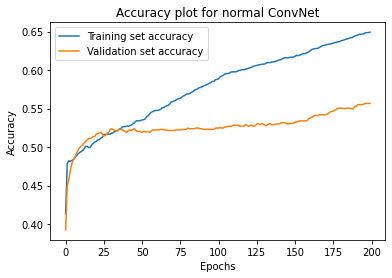

In [ ]:
plt.plot(model.history.history['accuracy'], label='Training set accuracy')
plt.plot(model.history.history['val_accuracy'], label='Validation set accuracy')
plt.title('Accuracy plot for normal ConvNet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('normal_acc_5_layer_conv.png')

In [ ]:
y = np.concatenate([y for x, y in ds_test], axis=0)

In [ ]:
preds = model.predict(ds_test)
preds.shape

(1279, 4)

In [ ]:
y = np.concatenate([y for x, y in ds_test], axis=0)
tf.math.confusion_matrix(np.argmax(y, axis = -1), np.argmax(preds, axis = -1))

<tf.Tensor: shape=(4, 4), dtype=int32, numpy=
array([[  0,   0, 115,  64],
       [  0,   0,  10,   2],
       [  0,   0, 602,  38],
       [  4,   0, 334, 110]], dtype=int32)>

In [ ]:
!pip install pretty-confusion-matrix

In [ ]:
conf_mat = tf.math.confusion_matrix(np.argmax(y, axis = -1), np.argmax(preds, axis = -1))

In [ ]:
conf_mat.numpy()

array([[  0,   0, 115,  64],
       [  0,   0,  10,   2],
       [  0,   0, 602,  38],
       [  4,   0, 334, 110]], dtype=int32)

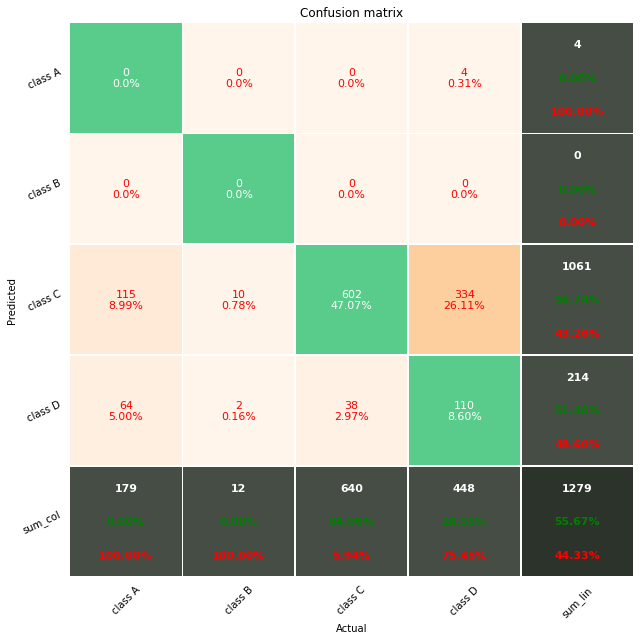

In [ ]:
from pretty_confusion_matrix import pp_matrix_from_data
pp_matrix_from_data(np.argmax(y, axis = -1), np.argmax(preds, axis = -1))

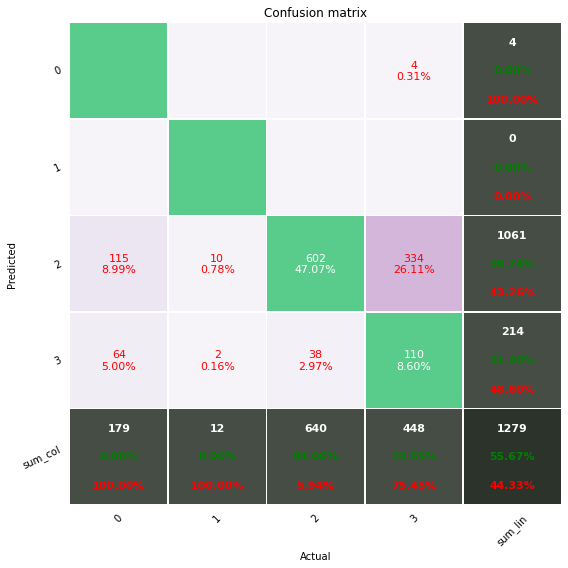

In [ ]:
from pretty_confusion_matrix import pp_matrix
df_cm = pd.DataFrame(conf_mat.numpy(), index=range(0, 4), columns=range(0, 4))
pp_matrix(df_cm, cmap='PuRd')

In [ ]:
model_VGGNET16 = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(208,176,3),
    pooling=None,
    classes=1000)
# model_VGGNET16.summary()
actual_model=tf.keras.models.Sequential()
actual_model.add(model_VGGNET16)
actual_model.add(tf.keras.layers.Flatten())
actual_model.add(tf.keras.layers.Dense(4096, activation="relu"))
# actual_model.add(tf.keras.layers.Dense(4096, a /ctivation="relu"))

actual_model.add(tf.keras.layers.Dense(512, activation="relu"))
actual_model.add(tf.keras.layers.Dense(256, activation="relu"))
actual_model.add(tf.keras.layers.Dense(4, activation="softmax"))

loss = tf.keras.losses.CategoricalCrossentropy()
optim = tf.keras.optimizers.Adam(learning_rate=1e-7)
metrics = ["accuracy","Precision","Recall"]
actual_model.compile(loss=loss , optimizer=optim, metrics=metrics)
m1=actual_model.fit(ds_train, validation_data=ds_test, epochs=200, verbose=2)

Epoch 1/200
167/167 - 61s - loss: 1.1964 - accuracy: 0.4667 - precision: 0.5000 - recall: 0.0190 - val_loss: 1.1284 - val_accuracy: 0.4996 - val_precision: 0.4510 - val_recall: 0.0719 - 61s/epoch - 366ms/step
Epoch 2/200
167/167 - 61s - loss: 1.1212 - accuracy: 0.4826 - precision: 0.5947 - recall: 0.1614 - val_loss: 1.0901 - val_accuracy: 0.4988 - val_precision: 0.5647 - val_recall: 0.2252 - 61s/epoch - 366ms/step
Epoch 3/200
167/167 - 63s - loss: 1.0952 - accuracy: 0.4922 - precision: 0.6621 - recall: 0.2426 - val_loss: 1.0724 - val_accuracy: 0.5004 - val_precision: 0.6034 - val_recall: 0.3057 - 63s/epoch - 375ms/step
Epoch 4/200
167/167 - 63s - loss: 1.0723 - accuracy: 0.4990 - precision: 0.6970 - recall: 0.2845 - val_loss: 1.0605 - val_accuracy: 0.5043 - val_precision: 0.6208 - val_recall: 0.3495 - 63s/epoch - 377ms/step
Epoch 5/200
167/167 - 63s - loss: 1.0499 - accuracy: 0.5074 - precision: 0.7157 - recall: 0.3029 - val_loss: 1.0516 - val_accuracy: 0.5043 - val_precision: 0.6159 -

KeyboardInterrupt: ignored

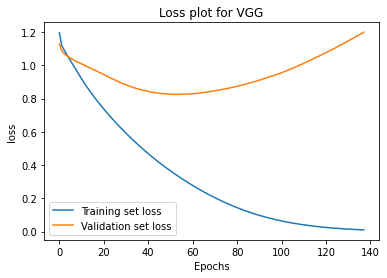

In [ ]:
plt.plot(actual_model.history.history['loss'], label='Training set loss')
plt.plot(actual_model.history.history['val_loss'], label='Validation set loss')
plt.title('Loss plot for VGG')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig('vgg_loss_5_layer_conv.png')

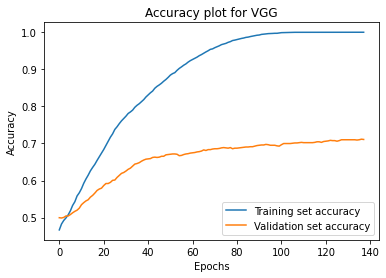

In [ ]:
plt.plot(actual_model.history.history['accuracy'], label='Training set accuracy')
plt.plot(actual_model.history.history['val_accuracy'], label='Validation set accuracy')
plt.title('Accuracy plot for VGG')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('vgg_acc_5_layer_conv.png')

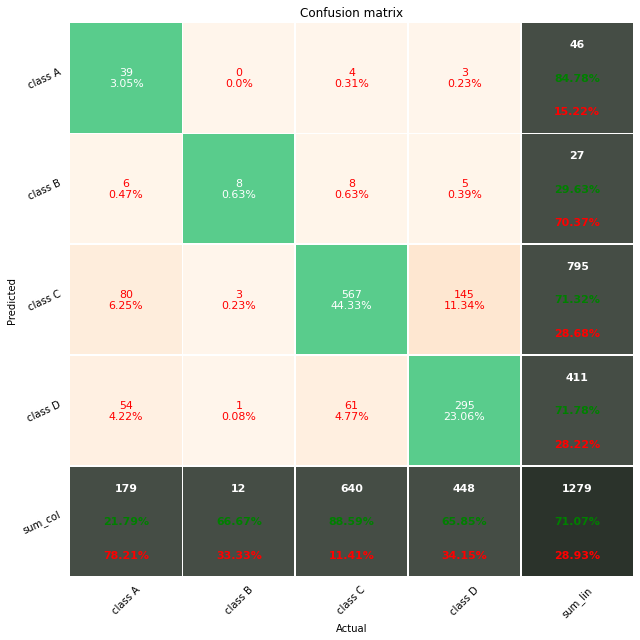

In [ ]:
from pretty_confusion_matrix import pp_matrix_from_data
preds = actual_model.predict(ds_test)
pp_matrix_from_data(np.argmax(y, axis = -1), np.argmax(preds, axis = -1))